# Imports

In [20]:
%matplotlib inline
from __future__ import division

import tools.convolution
from tools.readtree import readtree

from tqdm import tqdm

import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import plotly.offline as py
import plotly.graph_objs as GO

import astropy
import os
from scipy.signal import argrelextrema

from tools.extrema import extrema
from tools.convolution import convolution
import glob

py.init_notebook_mode()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.style.use(['beamer', 'ggplot'])

def savefig(figure, path):
    figure.savefig(path+'.png')
    figure.savefig(path+'.pdf')

time: 32.2 ms


In [2]:
%load_ext autotime
%load_ext line_profiler

# Load some data about halos

In [3]:
from tools.infos import read_infos
infos = read_infos('/data52/Horizon-AGN/OUTPUT_DIR/output_00002/info_00002.txt')['infos']

time: 101 ms


In [4]:
inertia_data = pd.read_hdf('data/halo_kin.00002.1e10_m.hdf')
print(str(inertia_data.index.size) + ' halos!')

280219 halos!
time: 412 ms


# Smoothing tree

## Set halo number

In [23]:
halo_i = 536

time: 1.07 ms


## Load data

In [24]:
from scipy.io import FortranFile as FF
ff = FF('smoothingtrees/11.5_logm_12_both/halo_%s-centers.bin' % halo_i)
ndim, noutput = ff.read_ints()
outputs = ff.read_ints()
centers = ff.read_reals().reshape((ndim, noutput))
outputs, centers

(array([782, 315,   2], dtype=int32),
 array([[ 0.14947477,  0.08983465,  0.98792952],
        [ 0.15795604,  0.08148159,  0.00544034],
        [ 0.16120237,  0.07834255,  0.02196565]]))

time: 10.8 ms


In [25]:
df = pd.read_csv('smoothingtrees/11.5_logm_12_both/halo_%s_around' % halo_i, delim_whitespace=True, engine='c', index_col=0)

time: 3.34 s


In [26]:
df[['x', 'y', 'z']].describe()

,x,y,z
count,2.240042e+06,2.240042e+06,2.240042e+06
mean,1.599301e-01,7.757383e-02,-2.826073e-02
std,2.930953e-02,2.845331e-02,5.888301e-02
min,-5.282836e-05,-1.804620e-05,-1.875076e-01
25%,1.344173e-01,5.319619e-02,-7.869376e-02
50%,1.587679e-01,7.713415e-02,-2.712791e-02
75%,1.855858e-01,1.017416e-01,2.354502e-02
max,2.112023e-01,1.283425e-01,7.196553e-02


time: 1.18 s


In [27]:
dfin = pd.read_csv('smoothingtrees/11.5_logm_12_both/halo_%s-00002' % halo_i, delim_whitespace=True, engine='c', index_col=0)
desc = dfin.describe()

center = desc.loc['mean'][['x', 'y', 'z']]
span = desc.loc['max'][['x', 'y', 'z']] - desc.loc['min'][ ['x', 'y', 'z']]

desc

,x,y,z,vx,vy,vz
count,7695.000000,7695.000000,7695.000000,7695.000000,7695.000000,7695.000000
mean,0.161202,0.078343,0.021966,-0.000002,0.000045,-0.000309
std,0.006639,0.011650,0.009254,0.000105,0.000203,0.000188
min,0.092394,0.024076,-0.008563,-0.000335,-0.000417,-0.000903
25%,0.158024,0.070002,0.015340,-0.000076,-0.000090,-0.000453
50%,0.161483,0.080123,0.022001,-0.000001,0.000036,-0.000345
75%,0.164670,0.086049,0.027574,0.000083,0.000151,-0.000139
max,0.180580,0.129052,0.077957,0.000634,0.000641,0.000110


time: 87.1 ms


In [28]:
left = center - 1.5*span
right = center + 1.5*span
df = df[df.x > left.x][df.y > left.y][df.z > left.z][df.x < right.x][df.y < right.y][df.z < right.z]

/home/cadiou/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



time: 3.26 s


In [29]:
df.describe()

,cpu,x,y,z
count,1.995944e+06,1.995944e+06,1.995944e+06,1.995944e+06
mean,4.189747e+02,1.602489e-01,7.809389e-02,-1.696713e-02
std,3.456677e+02,2.916589e-02,2.841183e-02,5.186835e-02
min,5.000000e+00,1.112024e-01,-1.804620e-05,-1.078139e-01
25%,1.000000e+01,1.348075e-01,5.376003e-02,-6.280930e-02
50%,7.070000e+02,1.592549e-01,7.799249e-02,-1.536070e-02
75%,7.100000e+02,1.857947e-01,1.022457e-01,2.829641e-02
max,7.660000e+02,2.112023e-01,1.283425e-01,7.196553e-02


time: 1.19 s


## Plot

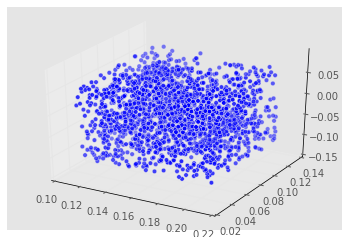

time: 670 ms


In [53]:
plt.figure()
ax = plt.subplot(111, projection='3d')
each = 1000
ax.scatter3D(df.x[::each], df.y[::each], df.z[::each])
plt.show()

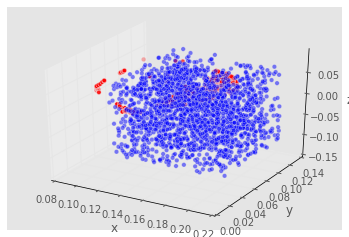

(cpu    5.000000
 x      0.112167
 y      0.029433
 z     -0.106032
 dtype: float64, cpu    764.000000
 x        0.210189
 y        0.127298
 z        0.070068
 dtype: float64)

time: 3.55 s


In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(df.x[::each], df.y[::each], df.z[::each], alpha=0.5)
ax.scatter3D(dfin.x, dfin.y, dfin.z,  c='red')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

df[['x', 'y', 'z']].mean(), dfin[['x', 'y', 'z']].mean()
plt.show()
df.quantile(0.01), df.quantile(0.99)

In [55]:
plt.close('all')

time: 1.27 ms


# Home made!

## Convolution

In [56]:
def f():
    pixs, pos, eigvect, eigvals, peaktype = extrema.extrema_get(ndim, npeak)
    #convert back pixs into
    index = np.array(np.unravel_index(pixs, conv.shape, order='F'))
    return dict(
        index = index,
        pos = pos,
        eigvect = eigvect,
        eigvals = eigvals,
        type = peaktype
    )

def as_df(peaks):
    df = pd.DataFrame(peaks['pos'].T, columns=['x', 'y', 'z'])
    df['i'] = df['j'] = df['k'] = 0
    df[['i', 'j', 'k']] = peaks['index'].T
    df['type'] = peaks['type']
    
    df['xr'] = df['i'] / edges[0].shape[0] * (edges[0].max() - edges[0].min()) + edges[0].min()
    df['yr'] = df['j'] / edges[1].shape[0] * (edges[1].max() - edges[1].min()) + edges[1].min()
    df['zr'] = df['k'] / edges[2].shape[0] * (edges[2].max() - edges[2].min()) + edges[2].min()
    
    return df

time: 21.9 ms


In [57]:
from tools.convolution import convolution
bins = 64
dens, edges = convolution.conv_density(df[['x', 'y', 'z']].as_matrix().T, bins)

time: 654 ms


In [58]:
gaussian = convolution.kernel_gaussian3d(bins, 2)
gfft = convolution.fft(gaussian)

time: 41.8 ms


In [59]:
hfft = convolution.fft(dens)
cfft = convolution.conv_prod(hfft, gfft)

conv = convolution.ifft(cfft)

time: 35 ms


In [60]:
from pymses.utils import constants as C
(infos.loc['unit_l'].value * C.cm).express(C.Mpc)

8.3721801909332374

time: 6.04 ms


In [61]:
extrema.npeaks = bins**3
extrema.nbins = np.array([bins, bins, bins])
extrema.npeaks, extrema.nbins

ndim, npeak = extrema.extrema_compute(np.asfortranarray(conv))
ndim, npeak

peaks = f()
dfp = as_df(peaks)

time: 2.91 s


/home/cadiou/.local/lib/python2.7/site-packages/ipykernel/__main__.py:24: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/cadiou/.local/lib/python2.7/site-packages/ipykernel/__main__.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



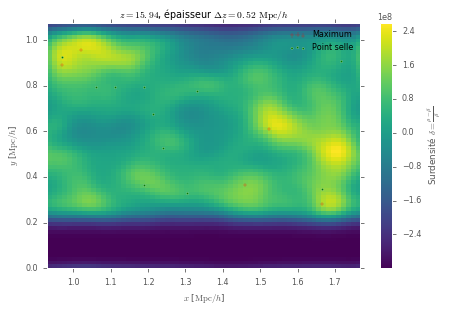

time: 1.15 s


In [62]:
%matplotlib inline
from pymses.utils import constants as C
from matplotlib.colors import LogNorm
with matplotlib.style.context(['seaborn-paper']):
    toMpc = (infos.loc['unit_l'].value * C.cm).express(C.Mpc)
    cmean = conv.mean()
    dens_mean = (conv - cmean) / cmean * 8e7 #Msun/DM particle
    cent = 28
    around = 2
    plt.imshow(dens_mean[:,:,cent-around:cent+around].sum(axis=2).T, origin='lower', 
               extent=(edges[0, 0]*toMpc, edges[0, -1]*toMpc, edges[1, 0]*toMpc, edges[1, -1]*toMpc), cmap='viridis',
               interpolation='none', aspect='auto')
    plt.xlim(edges[0, 0]*toMpc, edges[0, -1]*toMpc)
    plt.ylim(edges[1, 0]*toMpc, edges[1, -1]*toMpc)
    
    plt.xlabel('$x$ [$\mathrm{Mpc}/h$]')
    plt.ylabel('$y$ [$\mathrm{Mpc}/h$]')
    
    plt.title(u'$z=%.2f$, épaisseur $\Delta z = %.2f\ \mathrm{Mpc}/h$' % (1/(infos.loc['aexp']) - 1, around*2 / bins * toMpc))
    
    cb = plt.colorbar()
    cb.set_label(u'Surdensité ' + r'$\delta = \frac{\rho - \bar{\rho}}{\bar{\rho}}$')
        
    a = dfp[dfp.z >= cent-around][dfp.z <= cent+around][dfp.type == 4]
    plt.scatter(a.xr*toMpc, a.yr*toMpc, marker='+', c='red', label='Maximum')
    
    a = dfp[dfp.z >= cent-around][dfp.z <= cent+around][dfp.type == 3]
    plt.scatter(a.xr*toMpc, a.yr*toMpc, marker='.', c='green', label='Point selle')
    
    plt.grid('off')
    plt.legend(loc='best', framealpha=0)
    plt.tight_layout()
    plt.savefig('/home/cadiou/plots/paper/halo_%s_density.pdf'%halo_i)

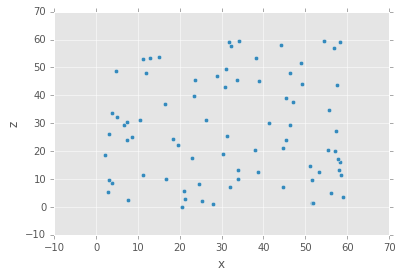

time: 329 ms


In [63]:
dfp[dfp.type==4].plot.scatter('x', 'z')

## Find extrema

In [64]:
print(conv.shape)
extrema.npeaks = bins**3
extrema.nbins = np.array([bins, bins, bins])
extrema.npeaks, extrema.nbins

(64, 64, 64)


(array(262144, dtype=int32), array([64, 64, 64], dtype=int32))

time: 8.43 ms


In [65]:
ndim, npeak = extrema.extrema_compute(np.asfortranarray(conv))
ndim, npeak

(3, 615)

time: 2.87 s


In [66]:
peaks = f()
dfp = as_df(peaks)

time: 13.5 ms


In [67]:
dfp[dfp.k == 32][dfp.type == 4]

/home/cadiou/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,x,y,z,i,j,k,type,xr,yr,zr
310,5.113334,18.814005,32.280304,5,19,32,4,0.118895,0.037503,-0.019307


time: 26.7 ms


70 of type min
246 of type saddle (1 max)
220 of type saddle (2 max)
79 of type max


(0.10000000000000001, 0.22)

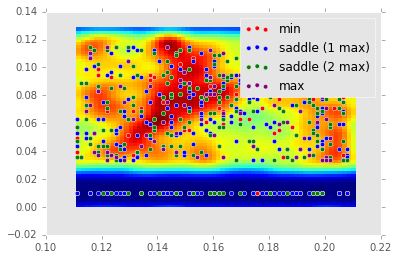

time: 523 ms


In [68]:
plt.pcolormesh(edges[0], edges[1], conv[:,:,5].T)

colors = ['red', 'blue', 'green', 'purple']
for i, (t, l) in enumerate(zip(range(1, 5), ['min', 'saddle (1 max)', 'saddle (2 max)', 'max'])):
    mask = (dfp.type == t)
    plt.scatter(dfp[mask].xr, dfp[mask].yr, c=colors[i], label=l)
    print('%i of type %s' % (dfp[mask].index.size, l))
plt.legend()

plt.xlim()

## All at once!

In [69]:
import cython

time: 1.29 ms


In [13]:
'''%%cython
# estimate density
from tools.convolution import convolution
from tools.extrema import extrema
cimport numpy as np
import numpy as np
import pandas as pd
from tqdm import tqdm

import cython

@cython.boundscheck(False)
@cython.wraparound(False)'''
def treat(df, bins=64,steps=5):
    #cdef np.ndarray[double,  ndim=3] dens, gaussian
    '''    cdef np.ndarray[double,  ndim=3] dens, gaussian
    cdef np.ndarray[complex, ndim=3] dfft, gfft
    cdef np.ndarray[double,  ndim=2] edges
    cdef np.ndarray[long,    ndim=2] index
    
    cdef np.ndarray[int] peaktype, pixs
    cdef np.ndarray[double, ndim=2] pos, eigvect
    cdef np.ndarray[double] eigvals
    cdef double sigma'''
    
    dens, edges = convolution.conv_density(df[['x', 'y', 'z']].as_matrix().T, bins)
    dfft = convolution.fft(dens)

    sigmas_list = np.linspace(1, bins // 2, steps)

    # peak finding
    extrema.npeaks = bins**3
    extrema.nbins = np.array([bins, bins, bins])
    extrema.nproc = 1
    dfpeak = pd.DataFrame()
    
    for sigma in tqdm(sigmas_list):
        # convolve
        gaussian = convolution.kernel_gaussian3d(bins, sigma)

        gfft = convolution.fft(gaussian)
        cfft = convolution.conv_prod(dfft, gfft)
        conv = convolution.ifft(cfft)

        ndim, npeak = extrema.extrema_compute(np.asfortranarray(conv))

        pixs, pos, eigvect, eigvals, peaktype = extrema.extrema_get(ndim, npeak)
        #convert back pixs into
        index = np.array(np.unravel_index(pixs, conv.shape, order='F'))

        dfpeak = dfpeak.append(pd.DataFrame(dict(
                    i=index[0, :], j=index[1, :], k=index[2, :], type=peaktype, eigval= eigvals,
                    x=pos[0], y=pos[1], z=pos[2],
                    evx= eigvect[0], evy=eigvect[1], evz=eigvect[2],
                    sigma=sigma
                    )))
        
    return dfpeak, dens, edges

time: 36 ms


In [30]:
bins = 32
dfpeak, dens, edges = treat(df, bins=bins, steps=40)

100%|██████████| 40/40 [00:15<00:00,  2.70it/s]

time: 16 s


In [31]:
dfpeak['amp'] = dfpeak.eval('evx**2 + evy**2 + evz**2')

time: 8.15 ms


In [32]:
print(str(dfpeak.index.size) + ' elements')
dfpeak.head()

1192 elements


,eigval,evx,evy,evz,i,j,k,sigma,type,x,y,z,amp
0,0.0,-1.617555e+08,-3.627976e+07,1.709402e+07,21,12,0,1.0,3,20.929665,12.127722,0.277280,2.777326e+16
1,0.0,-1.093266e+08,-1.746177e+07,3.031062e+07,22,14,0,1.0,3,22.334989,14.254539,0.447692,1.317596e+16
2,0.0,-4.401407e+05,2.051668e+05,2.060151e+07,4,2,1,1.0,2,3.626263,1.586947,0.854307,4.246579e+14
3,0.0,-6.880973e+05,-1.898427e+04,2.182883e+07,7,2,1,1.0,3,6.702199,1.542761,1.296756,4.769716e+14
4,0.0,-3.982544e+05,5.593225e+05,1.533294e+07,19,2,1,1.0,2,18.507671,1.576299,1.137176,2.355704e+14


time: 37.1 ms


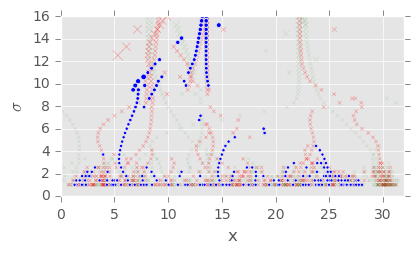

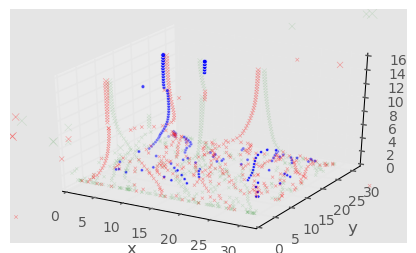

time: 3.31 s


In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

m = dfpeak.type==4

def mapon(lbound, ubound, maxval, minval, arr):
    maxarr = np.max(arr)
    minarr = np.min(arr)
    return (arr - minval)/(maxval - minval)*ubound + lbound


mmapon= lambda arr: mapon(5, 50, np.max(np.sqrt(1/dfpeak['amp'])), np.min(np.sqrt(1/dfpeak['amp'])), arr)

m = dfpeak.type == 3
ax.scatter3D(dfpeak[m]['x'], dfpeak[m]['y'], dfpeak[m]['sigma'], s=mmapon(np.sqrt(1/dfpeak[m]['amp'])), c='red', alpha=0.3, marker='x',
            label='Saddle point, 2 max')

m = dfpeak.type == 2
ax.scatter3D(dfpeak[m]['x'], dfpeak[m]['y'], dfpeak[m]['sigma'], s=mmapon(np.sqrt(1/dfpeak[m]['amp'])), c='green', alpha=0.1, marker='x',
            label='Saddle point, 1 max')

m = dfpeak.type == 4
ax.scatter3D(dfpeak[m]['x'], dfpeak[m]['y'], dfpeak[m]['sigma'], s=mmapon(np.sqrt(1/dfpeak[m]['amp'])), c='blue', marker='o',
            label='Peak')

ax.set_xlim(0, bins)
ax.set_ylim(0, bins)
ax.set_zlim(0, dfpeak['sigma'].max())

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\sigma$')

#ax.legend(loc='best')

fig.tight_layout()

savefig(plt.gcf(), '/home/cadiou/plots/smoothingtree/halo_%s' % halo_i)

ax.set_zlim(0, bins // 2)

savefig(plt.gcf(), '/home/cadiou/plots/smoothingtree/halo_%s_zoom' % halo_i)
plt.show()

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)

def mapon(lbound, ubound, maxval, minval, arr):
    maxarr = np.max(arr)
    minarr = np.min(arr)
    return (arr - minval)/(maxval - minval)*ubound + lbound


mmapon= lambda arr: mapon(5, 50, np.max(np.sqrt(1/dfpeak['amp'])), np.min(np.sqrt(1/dfpeak['amp'])), arr)

m = dfpeak.type == 3
ax.scatter(dfpeak[m]['x'],
           #dfpeak[m]['y'], 
           dfpeak[m]['sigma'], s=mmapon(np.sqrt(1/dfpeak[m]['amp'])), c='red', alpha=0.3, marker='x',
           label='Saddle point, 2 max')

m = dfpeak.type == 2
ax.scatter(dfpeak[m]['x'], 
           #dfpeak[m]['y'],
           dfpeak[m]['sigma'], s=mmapon(np.sqrt(1/dfpeak[m]['amp'])), c='green', alpha=0.1, marker='x',
           label='Saddle point, 1 max')

m = dfpeak.type == 4
ax.scatter(dfpeak[m]['x'], 
           #dfpeak[m]['y'], 
           dfpeak[m]['sigma'], s=mmapon(np.sqrt(1/dfpeak[m]['amp'])), c='blue', marker='o',
           label='Peak')

ax.set_xlim(0, bins)
ax.set_ylim(0, dfpeak['sigma'].max())

ax.set_xlabel('x')
ax.set_ylabel('$\sigma$')

#ax.legend(loc='best')

fig.tight_layout()

savefig(plt.gcf(), '/home/cadiou/plots/smoothingtree/halo_%s_2D' % halo_i)

ax.set_ylim(0, bins // 2)

savefig(plt.gcf(), '/home/cadiou/plots/smoothingtree/halo_%s_zoom_2D' % halo_i)

time: 1.47 s


In [35]:
plt.close('all')

time: 1.25 ms
